In [11]:
import talib
import sys
sys.path.append('../code/poloniex')
import polo_eda as pe


import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout, Candlestick
from plotly import tools
init_notebook_mode(connected=True)

In [2]:
df = pe.read_trade_hist()

In [3]:
df.head()

,amount,globalTradeID,rate,total,tradeID,type
date,,,,,,
2017-06-28 06:08:09,8.215384,179575864,0.015531,0.127597,8102473,buy
2017-06-28 06:08:09,14.992102,179575863,0.015530,0.232827,8102472,buy
2017-06-28 06:08:09,21.675132,179575862,0.015527,0.336543,8102471,buy
2017-06-28 06:08:09,19.499969,179575861,0.015521,0.302658,8102470,buy
2017-06-28 06:08:08,0.026881,179575857,0.015521,0.000417,8102469,buy


In [58]:
def create_tas(df):
    # create ohlc bars
    ticks = df.loc[:, ['rate', 'amount']].iloc[::-1]
    bars = ticks['rate'].resample('1min').ohlc()
    bars = bars.fillna(method='ffill')
    bars['tp'] = (bars['high'] + bars['low'] + bars['close']) / 3
    
    # bollinger bands
    # strange bug, if values are small, need to multiply to larger value for some reason
    mult = 1
    last_close = bars.iloc[0]['close']
    lc_m = last_close * mult
    while lc_m < 1:
        mult *= 10
        lc_m = last_close * mult
    
    print('using multiplier of', mult)
    
    upper2, middle2, lower2 = talib.BBANDS(bars['tp'].values*mult,
                                    timeperiod=10,
                                    nbdevup=2,
                                    nbdevdn=2)

    upper1, middle1, lower1 = talib.BBANDS(bars['tp'].values*mult,
                                timeperiod=10,
                                nbdevup=1,
                                nbdevdn=1)

    upper2 /= mult
    middle2 /= mult
    lower2 /= mult
    upper1 /= mult
    lower1 /= mult
    bars['bband_u2'] = upper2
    bars['bband_m'] = middle2
    bars['bband_l2'] = lower2
    bars['bband_u2'].fillna(method='bfill', inplace=True)
    bars['bband_m'].fillna(method='bfill', inplace=True)
    bars['bband_l2'].fillna(method='bfill', inplace=True)
    bars['bband_u1'] = upper1
    bars['bband_l1'] = lower1
    bars['bband_u1'].fillna(method='bfill', inplace=True)
    bars['bband_l1'].fillna(method='bfill', inplace=True)
    
    # note: too small of a timeperiod will result in junk data...I think.  or at least very discretized
    mom = talib.MOM(bars['close'].values*mult, timeperiod=14)
    
    bars['mom'] = mom/mult
    bars['mom'].fillna(method='bfill', inplace=True)
    
    return bars

In [5]:
def reject_outliers(sr, iq_range=0.5):
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return sr[ (sr - median).abs() <= iqr]

def remove_outliers(df):
    """
    removes outliers for EDA
    """
    data = {}
    for c in df.columns:
        print(c)
        data[c] = reject_outliers(df[c])
    
    return data

In [6]:
df2 = create_tas(df)

using multiplier of 100


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1810183 entries, 2014-01-18 04:26:00 to 2017-06-28 06:08:00
Freq: T
Data columns (total 8 columns):
open       float64
high       float64
low        float64
close      float64
bband_u    float64
bband_m    float64
bband_l    float64
mom        float64
dtypes: float64(8)
memory usage: 124.3 MB


In [8]:
df2.head()

,open,high,low,close,bband_u,bband_m,bband_l,mom
date,,,,,,,,
2014-01-18 04:26:00,0.028,0.028,0.028,0.028,0.0295,0.0285,0.0275,0.0
2014-01-18 04:27:00,0.028,0.028,0.028,0.028,0.0295,0.0285,0.0275,0.0
2014-01-18 04:28:00,0.028,0.028,0.028,0.028,0.0295,0.0285,0.0275,0.0
2014-01-18 04:29:00,0.028,0.028,0.028,0.028,0.0295,0.0285,0.0275,0.0
2014-01-18 04:30:00,0.028,0.028,0.028,0.028,0.0295,0.0285,0.0275,0.0


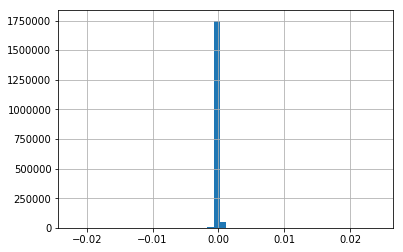

In [12]:
f = df2['mom'].hist(bins=50)

In [13]:
data = remove_outliers(df2)

open
high
low
close
bband_u
bband_m
bband_l
mom


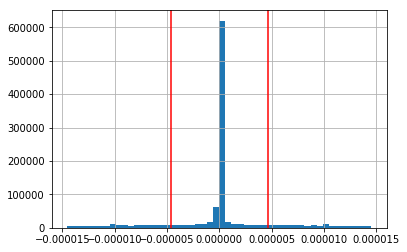

In [14]:
f = data['mom'].hist(bins=50)
l = plt.axvline(data['mom'].std(), c='r')
l = plt.axvline(-data['mom'].std(), c='r')

# for now, notify if above or below 1 std of MOM

In [15]:
data['mom'].std()

4.6504301513332678e-06

In [16]:
upper, middle, lower = talib.BBANDS(df['rate'].values, matype=talib.MA_Type.T3)

In [17]:
df.head()

,amount,globalTradeID,rate,total,tradeID,type
date,,,,,,
2017-06-28 06:08:09,8.215384,179575864,0.015531,0.127597,8102473,buy
2017-06-28 06:08:09,14.992102,179575863,0.015530,0.232827,8102472,buy
2017-06-28 06:08:09,21.675132,179575862,0.015527,0.336543,8102471,buy
2017-06-28 06:08:09,19.499969,179575861,0.015521,0.302658,8102470,buy
2017-06-28 06:08:08,0.026881,179575857,0.015521,0.000417,8102469,buy


In [24]:
small_df = df.iloc[:10000] # goes from latest to earliest
# dates = small_df.index

# data = [Scatter(
#             x=dates,
#             y=small_df['rate'].values),
#        Scatter(x=dates, y=upper[:10000]),
#        Scatter(x=dates, y=middle[:10000]),
#        Scatter(x=dates, y=lower[:10000])]
# fig = Figure(data=data)
# iplot(fig)

In [25]:
ticks = small_df.loc[:, ['rate', 'amount']]
bars = ticks['rate'].resample('1min').ohlc()
bars = bars.fillna(method='ffill')

In [27]:
bars.head()

,open,high,low,close
date,,,,
2017-06-27 21:09:00,0.015707,0.015745,0.015707,0.015736
2017-06-27 21:10:00,0.015707,0.015740,0.015707,0.015707
2017-06-27 21:11:00,0.015707,0.015754,0.015707,0.015746
2017-06-27 21:12:00,0.015746,0.015746,0.015720,0.015720
2017-06-27 21:13:00,0.015707,0.015728,0.015687,0.015687


In [26]:
trace = Candlestick(bars, x=bars.index)
dates = bars.index
# http://pythontrader.blogspot.com/2015/05/ta-lib-usage-bollinger-bands.html
upper2, middle2, lower2 = talib.BBANDS(bars['close'].values*100, # goddam weird bug, can't deal with small values, but only with pandas data...wtf
                                    timeperiod=10,
                                    nbdevup=2,
                                    nbdevdn=2)#,
                                    #matype=0)  # SMA

upper1, middle1, lower1 = talib.BBANDS(bars['close'].values*100, # goddam weird bug, can't deal with small values, but only with pandas data...wtf
                                    timeperiod=10,
                                    nbdevup=1,
                                    nbdevdn=1)#,
                                    #matype=0)  # SMA

scatters = [Scatter(x=dates, y=upper2/100, name='upper2'),
           Scatter(x=dates, y=middle2/100, name='middle'),
           Scatter(x=dates, y=lower2/100, name='lower2'),
           Scatter(x=dates, y=upper1/100, name='upper1'),
           Scatter(x=dates, y=lower1/100, name='lower1')]

data = [trace] + scatters
iplot(data, filename='simple_candlestick')

# [investopedia bollenger band strategy](http://www.investopedia.com/articles/trading/05/022205.asp): buy when 75% of bar is above 1 SD and green, sell when 75% of bar is below 1 SD and red
# ignore bars that are less than 50% open-close / hi-lo, maybe also look at the SD def from investopedia (SD of Hi + Lo + Cl / 3)

In [85]:
def generate_signals(bars):
    """
    Takes a candlestick bars dataframe and generates buy/sell signals for going long.
    Buy signals are when 75% of bar is above 1SD BB and bar is green, sell is when 75% of bar is 
    below 1SD and bar is red. Ignore bars where  
    """
    mult = 100
    signals = []
    bought = False
    for i, r in bars.iterrows():
        close_open = (r['close'] - r['open'])*mult
        # first check if bar should be ignored
        high_low = (r['high'] - r['low'])*mult
        if high_low == 0:
            signals.append(0)
            continue
        if abs(close_open) / high_low < 0.5 and not bought:
            signals.append(0)
            continue
        
        
        if bought:
            # check for sell signal if already bought
            if close_open < 0:  # bar is red
                # if 75% of bar is below bb with SD 1
                if (r['bband_u1'] - r['close'])*mult / -close_open >= 0.75:
                    signals.append(-1)
                    bought = False
                    continue
            
            signals.append(0)
        else:
            # check for buy signals
            if close_open > 0:  # bar is green
                # if 75% of bar is above bb SD 1
                if (r['close'] - r['bband_u1'])*mult / close_open >= 0.75:
                    signals.append(1)
                    bought = True
                    continue
            
            signals.append(0)
                
    return signals

In [86]:
bars = create_tas(small_df)

using multiplier of 100


In [87]:
signals = generate_signals(bars)

In [88]:
trace = Candlestick(bars[['open', 'close', 'high', 'low']], x=bars.index)
dates = bars.index
scatters = [Scatter(x=dates, y=bars['bband_u2'], name='upper2'),
           Scatter(x=dates, y=bars['bband_u1'], name='upper1')]
        
fig = tools.make_subplots(rows=2, cols=1, shared_xaxes=True)#, specs=[[{}], [{}]])
data = [trace] + scatters
for d in data:
    fig.append_trace(d, 1, 1)
fig.append_trace(Scatter(x=dates, y=signals, name='signals'), 2, 1)
iplot(fig, filename='buy_sell_test')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]



In [60]:
mom = talib.MOM(bars['close'].values, timeperiod=5)

In [61]:
# need to make this a subplot type thing
dates = bars.index
trace = Candlestick(bars, x=dates)

scatters = [Scatter(x=dates, y=mom, name='MOM')]

data = [trace] + scatters
iplot(data)

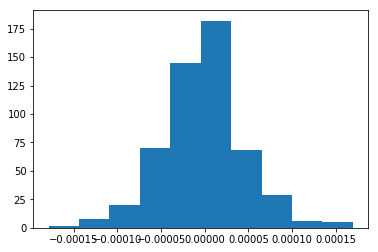

In [153]:
f = plt.hist(mom[5:])  # first few values are nans